In [3]:
import numpy as np
import pandas as pd
from radioReduction import *
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.optimize as op
import random
import emcee
import corner
from astropy.stats import LombScargle


In [4]:
'''
Importing the data and binning every 10 seconds
'''
dt = pd.read_table('1314/dataTables/2M1314e19-LLRR.dat')
dt = dt[dt['nsamp']>1000]
binned = binning(dt,sec=10,binning=2)

def binPlot(Type='minutes'):
    if Type == 'minutes':
        plt.errorbar(binned['dtmin'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['dtmin'],binned['re'],color='black',label='Data')
    else:
        plt.errorbar(binned['secs'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['secs'],binned['re'],color='black',label='Data') 

/home/russell/projects/radio_project/radioReduction.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['secs'] = data['dtmin']*60


In [5]:
'''
Defining our model, likelihoood, and prior functions
'''
def linearModel(theta,x):
    '''
    Linear model fitting to the data
    '''
    m,b = theta
    y = m*x+b
    return y

def lnprior(theta):
    '''
    Uniform priors for m and b constrained by the data
    '''
    m,b = theta
    if -1 < m < .5 and 1.6 < b < 2.2:
        return 0.0
    return -np.inf

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-linearModel(theta,x))**2/yerr**2))

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [6]:
# Putting data to variables
x = binned['dtmin']
y = binned['re']
yerr = binned['ure']

In [5]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
nll = lambda *args: -lnlike(*args)
x0 = [5,3]
linearResult = op.minimize(nll,x0,args=(x,y,yerr))
m_ml,b_ml = linearResult.x
print(m_ml,b_ml)


-0.03014505219614916 1.9574738159639025


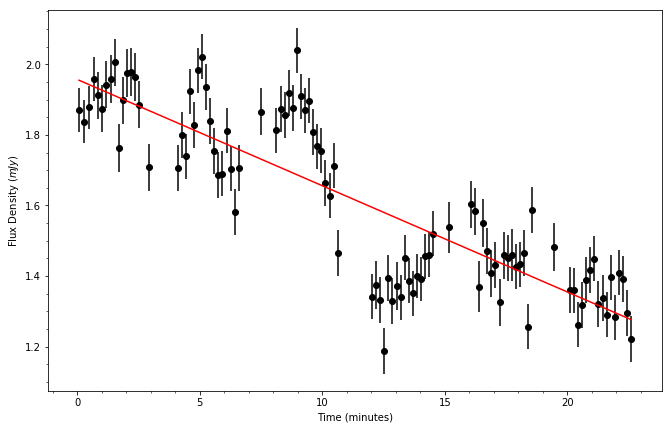

In [7]:
# Plotting results from maximized likelihood
plt.figure(figsize=(11,7))
binPlot(Type='minutes')
plt.plot(x,linearModel([m_ml,b_ml],x),color='red',label='Linear Model')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e19_linearModel.png')
plt.show()

In [8]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 2,100

# Initial position somewhere close to the maximum likelihood result
p0 = [linearResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
linearSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = linearSampler.run_mcmc(p0,500)
linearSampler.reset()

# Running MCMC
linearSampler.run_mcmc(pos,5000)

(array([[-0.02874407,  1.93674735],
        [-0.03095943,  1.96890917],
        [-0.02890671,  1.94392605],
        [-0.03074834,  1.96315141],
        [-0.03180566,  1.97826871],
        [-0.03082522,  1.9593587 ],
        [-0.03043503,  1.964504  ],
        [-0.02861329,  1.93900764],
        [-0.03060262,  1.96069576],
        [-0.03017792,  1.96604299],
        [-0.02910833,  1.94591117],
        [-0.03120572,  1.96924862],
        [-0.02787467,  1.93518249],
        [-0.03134201,  1.96646991],
        [-0.03040927,  1.94768997],
        [-0.03235541,  1.9732337 ],
        [-0.02835678,  1.94244674],
        [-0.03131899,  1.97923641],
        [-0.02952865,  1.95542889],
        [-0.0302961 ,  1.96462153],
        [-0.03021228,  1.95834041],
        [-0.02997786,  1.95040151],
        [-0.03086494,  1.97213522],
        [-0.02782403,  1.9239559 ],
        [-0.03131195,  1.96069096],
        [-0.02918889,  1.94443956],
        [-0.03022787,  1.96102071],
        [-0.03005312,  1.949

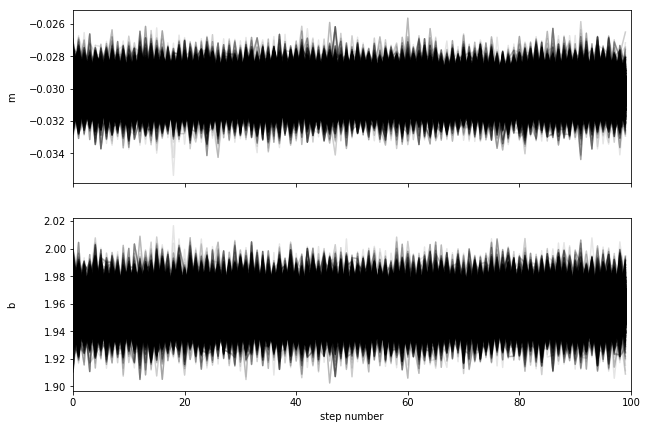

In [9]:
# Plotting the chains
fig, axes = plt.subplots(2,figsize=(10,7),sharex=True)
linearSamples = linearSampler.chain
labels = ['m','b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(linearSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(linearSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e19_linearTrace.png')
plt.show()

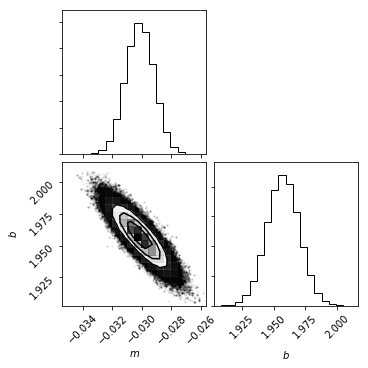

In [10]:
# Flattening the sampler
linearFlat = linearSampler.chain[:,:,:].reshape((-1,ndim))

fig = corner.corner(linearFlat,labels=['$m$','$b$'])
plt.savefig('plots/1314e19_linearCorner.png')
plt.show()

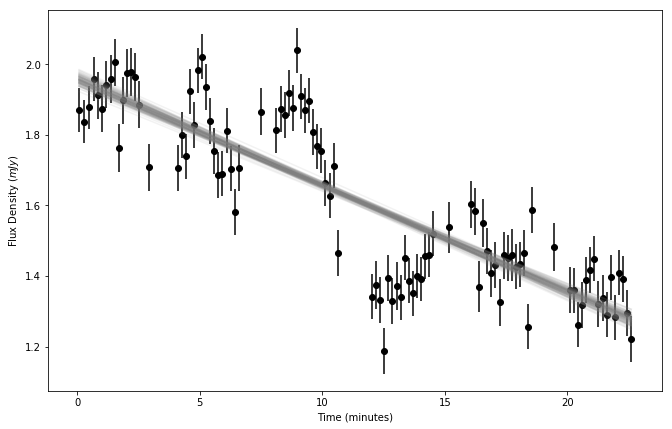

In [11]:
# Plotting first few MCMC steps on the data
plt.figure(figsize=(11,7))
binPlot(Type='minutes')
for m,b in linearFlat[np.random.randint(len(linearFlat),size=100)]:
    plt.plot(binned['dtmin'],m*binned['dtmin']+b,color='gray',alpha=0.1)
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/1314e19_500mcmc_data.png')
plt.show()

In [12]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(linearFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

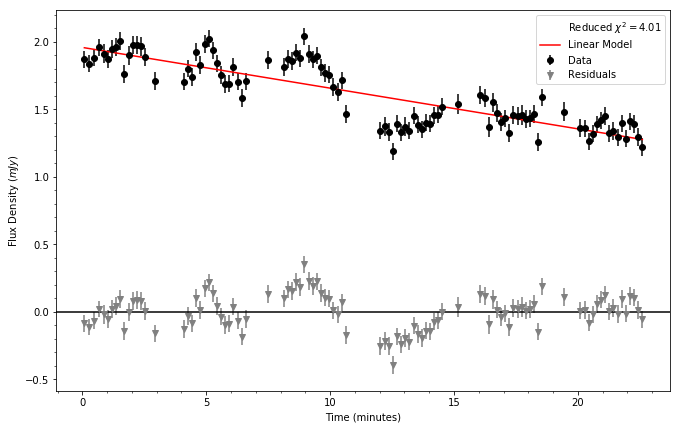

In [16]:
# Getting the 50th percentile of each parameter
linearParameters = []

for i in range(ndim):
    linearParameters.append(np.percentile(linearFlat[:,i],50))
linearParameters = np.array(linearParameters)

# Making model line
linear_model = linearModel(linearParameters,x)

# Residuals
linear_resid = y - linear_model

# Plotting the 50th percentile against the data along with residuals
plt.figure(figsize=(11,7))
plt.plot([],[],' ',label='Reduced $\chi^2 = 4.01$')
plt.errorbar(x,y,yerr=yerr,color='black',linestyle='None',label='Data',fmt='o')
plt.plot(x,linear_model,color='red',label='Linear Model')
plt.errorbar(x,linear_resid,yerr=yerr,color='gray',linestyle='None',label='Residuals',fmt='v')
plt.axhline(y=0,color='black')
plt.legend(loc='best')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e19_linearModel_fit.png')
plt.show()

In [14]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-linearModel(theta,x))/yerr))
chiSquare(linearParameters,y,yerr)/(len(x)-2)

4.009128957403618

## Fitting an logistic function


In [14]:
def logModel(theta,x):
    '''
    Logistic model w/ added term y0 to translate it up
    '''
    l,k,x0,y0 = theta
    denom = 1+np.exp(-k*(x-x0))
    return y0+l/denom

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-logModel(theta,x))**2/yerr**2))

def lnprior(theta):
    '''
    Uniform priors for a and b constrained by the data
    '''
    l,k,x0,y0 = theta
    if -2.5 < l < 0 and -5 < k < 10 and 9 < x0 < 15 and 1.6 < y0 < 2.0:
        return 0.0
    return -np.inf

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [6]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
x = binned['dtmin']
nll = lambda *args: -lnlike(*args)
p0 = [2,6,10,1]
logResult = op.minimize(nll,p0,args=(x,y,yerr))
l_ml,k_ml,x0_ml,y0_ml = logResult.x

print(l_ml,k_ml,x0_ml,y0_ml)

-0.4602288885951941 3.5279560200189466 10.366496002677042 1.8564805290430002


In [19]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 4,100

# Initial position somewhere close to the maximum likelihood result
p0 = [logResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
logSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = logSampler.run_mcmc(p0,500)
logSampler.reset()

# Running MCMC
logSampler.run_mcmc(pos,5000)

(array([[-0.46322578,  3.9834221 , 10.39893465,  1.85686262],
        [-0.4441122 ,  5.45080392, 10.44032095,  1.84383156],
        [-0.45864667,  3.44337004, 10.51998759,  1.86075027],
        [-0.45859904,  5.26364097, 10.47439897,  1.86211642],
        [-0.44535272,  4.31629028, 10.44682914,  1.8361494 ],
        [-0.47514883,  2.50098288, 10.58761112,  1.86681746],
        [-0.46225133,  4.23180926, 10.46701374,  1.8572428 ],
        [-0.46783759,  4.12256923, 10.43654021,  1.85471789],
        [-0.47290103,  3.81781158, 10.50872819,  1.85577986],
        [-0.42593483,  3.7593601 , 10.39835725,  1.84573493],
        [-0.47607142,  3.18779584, 10.40319559,  1.86562118],
        [-0.43948112,  3.65236183, 10.41057688,  1.849943  ],
        [-0.45230112,  3.47801208, 10.47842626,  1.85295978],
        [-0.45300197,  3.50829112, 10.40750624,  1.85728208],
        [-0.44607555,  4.33154151, 10.31908736,  1.84908589],
        [-0.45166454,  4.32210615, 10.5022783 ,  1.84215272],
        

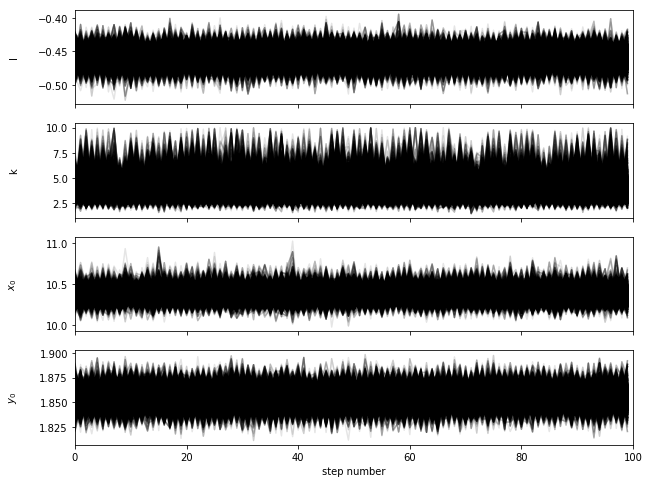

In [20]:
# Plotting the chains
fig, axes = plt.subplots(4,figsize=(10,8),sharex=True)
logSamples = logSampler.chain
labels = ['l','k','$x_0$','$y_0$']
for i in range(4):
    ax = axes[i]
    ax.plot(logSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(logSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e19_Trace.png')
plt.show()

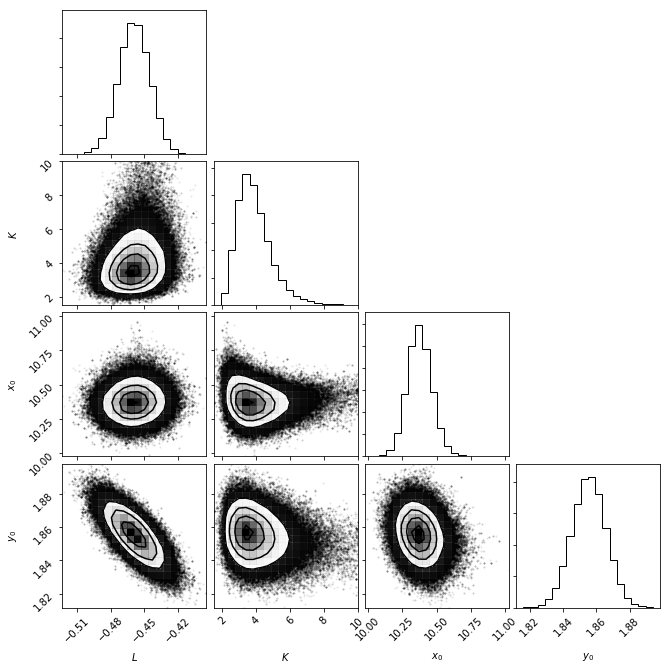

In [21]:
# Flattening the sampler
logFlat = logSampler.chain[:,:,:].reshape((-1,4))
fig = corner.corner(logFlat,labels=['$L$','$K$','$x_0$','$y_0$'])
plt.savefig('plots/1314e19_logCorner.png')
plt.show()

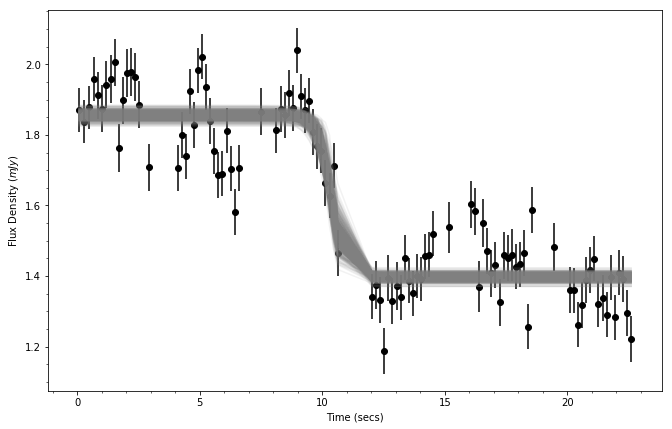

In [24]:
# Plotting first few MCMC steps on the data
plt.figure(figsize=(11,7))
binPlot(Type='minutes')
for l,k,x0,y0 in logFlat[np.random.randint(len(logFlat),size=500)]:
    plt.plot(x,logModel([l,k,x0,y0],x),color='gray',alpha=0.1)
plt.xlabel('Time (secs)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e19_500mcmc_log.png')
plt.show()

In [16]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(4):
    mcmc = np.percentile(logFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

NameError: name 'logFlat' is not defined

In [17]:
# -0.45148,3.39156,10.39780,1.84333

# Getting the 50th percentile of each parameter
logParameters = []

for i in range(4):
    logParameters.append(np.percentile(logFlat[:,i],50))
logParameters = np.array(logParameters)

# Making logistic model
log_model = logModel(logParameters,x)

# Calculating residuals
logResid = y - log_model

# Plotting against the data
plt.figure(figsize=(11,7))
binPlot(Type='minutes')
plt.plot([],[],' ',label='Reduced $\chi^2 = 2.20$')
plt.plot(x,log_model,color='red',label='Logistic Model')
plt.scatter(x,logResid,color='gray',marker='v',label='Residuals')
plt.errorbar(x,logResid,yerr=yerr,color='gray',label='_nolegend_',linestyle='None')
plt.axhline(y=0,color='black')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.minorticks_on()
plt.savefig('plots/1314e19_logModel.png')
plt.show()

NameError: name 'logFlat' is not defined

In [18]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-logModel(theta,x))/yerr))
chiSquare(logParameters,y,yerr)/(len(x)-4)

ValueError: not enough values to unpack (expected 4, got 0)

In [19]:
plt.figure(figsize=(11,7))
plt.scatter(x,logResid,color='black',marker='o',label='Residuals')
plt.errorbar(x,logResid,yerr=yerr,color='black',label='_nolegend_',linestyle='None')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.ylim(-1,1)
plt.minorticks_on()
plt.show()

NameError: name 'logResid' is not defined

<Figure size 792x504 with 0 Axes>

## e19 Looking at Stokes I, V and circular polarization

In [20]:
rr = pd.read_table('1314/dataTables/2M1314e19-RR.dat')
ll = pd.read_table('1314/dataTables/2M1314e19-LL.dat')


rr = rr[rr['nsamp']>1000]
ll = ll[ll['nsamp']>1000]
rr = binning(rr,10,2)
ll = binning(ll,10,2)

/home/russell/projects/radio_project/radioReduction.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['secs'] = data['dtmin']*60


In [21]:
stI = (rr['re']+ll['re'])*.5
stV = (rr['re']-ll['re'])*.5
frac = stV/stI
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5
time = rr['dtmin']

In [22]:
data = pd.DataFrame(data={'time':time,'stI':stI,'stErr':stErr})
data.to_csv('stokesI.csv')

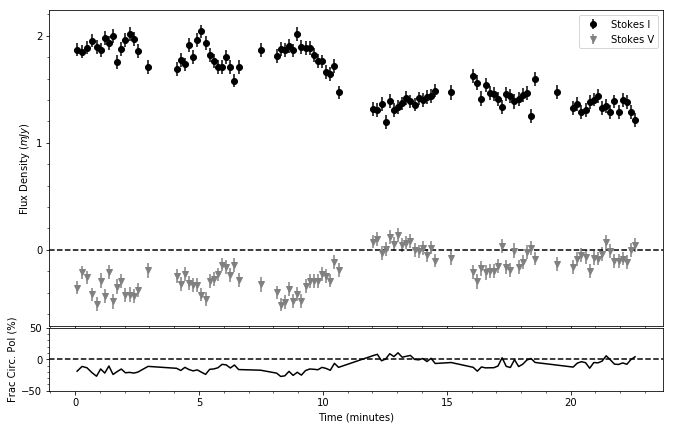

In [23]:
fig,ax = plt.subplots(figsize=(11,7),nrows=2,ncols=1,sharex=True,gridspec_kw = {'hspace':0.01,'height_ratios':[5,1]})
ax[0].errorbar(time,stI,yerr=stErr,color='k',linestyle='None',label='Stokes I',fmt='o')
ax[0].errorbar(time,stV,yerr=stErr,color='gray',linestyle='None',label='Stokes V',fmt='v')
ax[0].axhline(y=0,color='k',linestyle='dashed')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].locator_params(axis='y',nbins=4)
ax[0].minorticks_on()

ax[1].plot(time,100*frac,color='k')
ax[1].axhline(y=0,color='k',linestyle='--')
ax[1].set_ylim(-50,50)
ax[1].set_ylabel('Frac Circ. Pol (%)')
ax[1].minorticks_on()

plt.xlabel('Time (minutes)')
plt.savefig('plots/1314e19_stokes.png')
plt.show()

99


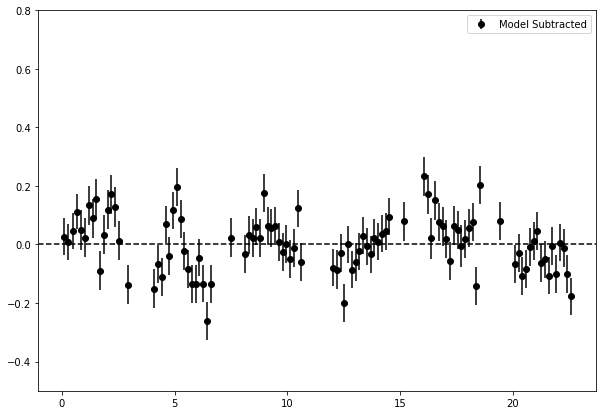

In [24]:
log_model = logModel([-0.45148,3.39156,10.39780,1.84333],x)

modelSub = stI - log_model
print(len(modelSub))

plt.figure(figsize=(10,7))
plt.errorbar(time,modelSub,yerr=stErr,color='k',linestyle='None',marker='o',label='Model Subtracted')
plt.axhline(y=0,color='k',linestyle='dashed')
plt.ylim(-0.5,0.8)
plt.legend(loc='best')
plt.show()

In [25]:
'''
Calculating the average Stokes V value in quiescent and active emission states
'''

stokes = (stI,stV,time,stErr)
activeV = stokes[1][stokes[2]<10.4]
activeErr = stokes[3][stokes[2]<10.400]
activeErr = 1/np.sqrt(np.sum(1/np.square(activeErr)))

quieV = stokes[1][stokes[2]>10.40]
quieErr = stokes[3][stokes[2]>10.40]
quieErr = 1/np.sqrt(np.sum(1/np.square(quieErr)))



print(np.average(activeV),activeErr,np.average(quieV),quieErr)

-0.3287052713382214 0.009474495278163192 -0.06103334538609673 0.00899263898106567


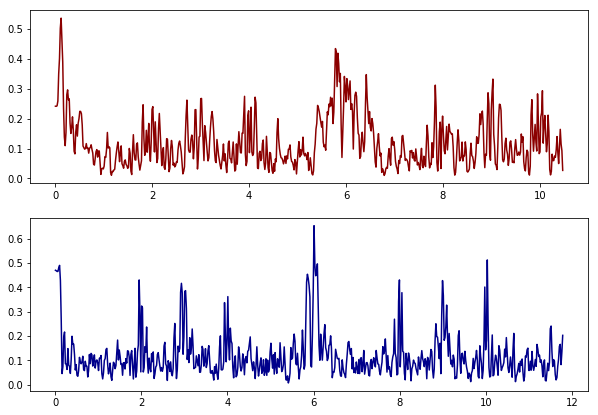

NameError: name 'lomb' is not defined

In [26]:
# On-state
freq1, power1 = LombScargle(time[:50],modelSub[:50],stErr[:50],nterms=3).autopower()

# Quiesent 
freq2, power2 = LombScargle(time[50:],modelSub[50:],stErr[50:],nterms=3).autopower()

# Plotting the freq vs power
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,7))
ax[0].plot(freq1,power1,color='darkred')
ax[1].plot(freq2,power2,color='darkblue')
plt.show()

# Making pandas table of the values
lomb1 = pd.DataFrame(data={'freq':freq1,'power':power1,'time':1/freq1*60})
lomb1 = lomb.sort_values('power',ascending=False)

lomb2 = pd.DataFrame(data={'freq':freq2,'power':power2,'time':1/freq2*60})
lomb2 = lomb.sort_values('power',ascending=False)

# Making models
best_freq1 = lomb1['freq'].iloc[1]
x_fit1 = np.linspace(np.min(time[:50]),np.max(time[:50]))
y_fit1 = LombScargle(time[:50],modelSub[:50],stErr[:50],nterms=1).model(x_fit1,best_freq1)

best_freq2 = lomb2['freq'].iloc[1]
x_fit2 = np.linspace(np.min(time[50:]),np.max(time[50:]))
y_fit2 = LombScargle(time[50:],modelSub[50:],stErr[50:],nterms=1).model(x_fit2,best_freq2)

plt.figure(figsize=(10,7))
plt.errorbar(time,modelSub,color='black',yerr=stErr,marker='o',linestyle='None')
plt.plot(x_fit1,y_fit1,color='darkred',label='On State')
plt.plot(x_fit2,y_fit2,color='darkblue',label='Off State')
plt.show()

print(1/best_freq1,1/best_freq2)


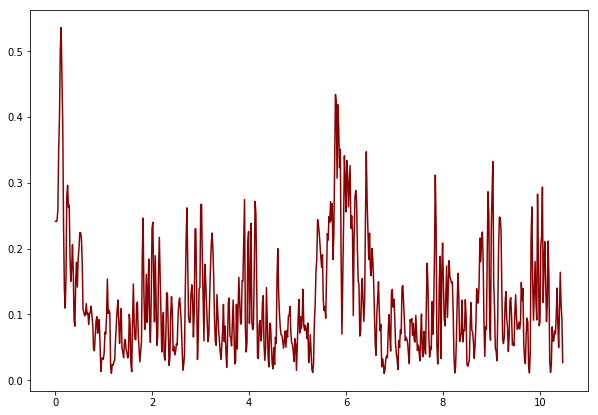

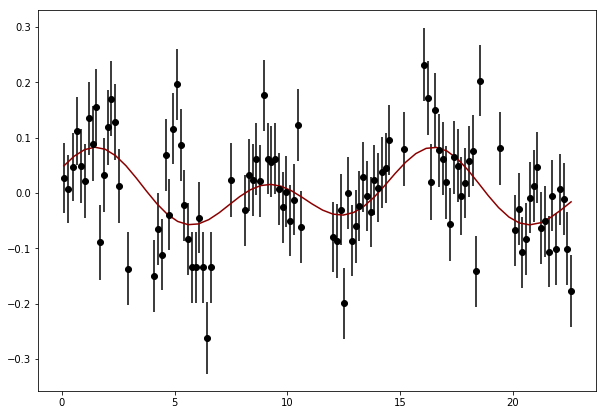

15.011111113708466


In [24]:
# The whole thing
freq, power = LombScargle(time,modelSub,stErr,nterms=3).autopower()

# Plotting the freq vs power
plt.figure(figsize=(10,7))
plt.plot(freq1,power1,color='darkred')

# Making pandas table of the values
lomb = pd.DataFrame(data={'freq':freq,'power':power,'time':1/freq*60})
lomb = lomb.sort_values('power',ascending=False)

# Making models
best_freq = lomb['freq'].iloc[0]
x_fit = np.linspace(np.min(time),np.max(time))
y_fit = LombScargle(time,modelSub,stErr,nterms=2).model(x_fit,best_freq)

# plotting data and model
plt.figure(figsize=(10,7))
plt.errorbar(time,modelSub,color='black',yerr=stErr,marker='o',linestyle='None')
plt.plot(x_fit,y_fit,color='darkred')
plt.show()

print(1/best_freq)



In [27]:
high = pd.read_table('1314/dataTables/2M1314e19-7GHz.dat')
low = pd.read_table('1314/dataTables/2M1314e19-5GHz.dat')

high = high[high['nsamp']>3000]
low = low[low['nsamp']>3000]

high = binning(high,10,2)
low = binning(low,10,2)


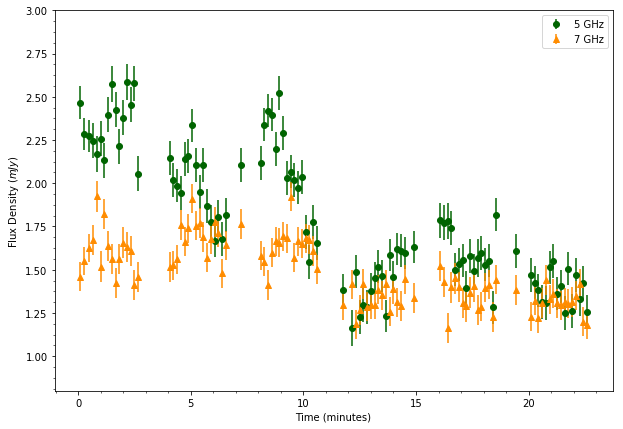

In [28]:
plt.figure(figsize=(10,7))
plt.errorbar(low['dtmin'],low['re'],yerr=low['ure'],marker='o',color='darkgreen',linestyle='None',label='5 GHz')
plt.errorbar(high['dtmin'],high['re'],yerr=high['ure'],marker='^',color='darkorange',linestyle='None',label='7 GHz')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.ylim(0.8,3)
plt.minorticks_on()

plt.savefig('plots/1314_e19_SED.png')
plt.show()

In [29]:
low['re'].max()

2.586633281460869

In [30]:
2.5e9*(2.58)*(5)**-2*16.39**2*2**-2

17326770450.000004